## NDBC data - analysis of wind vector time series

This notebook demonstrates common time series analysis techniques with a two-dimensional data set: wind velocity from a meteorological buoy offshore of Monterey Bay. The buoy is maintained by the National Data Buoy Center (NDBC).

The goal of this analysis is to rotate the wind data into an alongshore component (the wind blowing parallel to shore) and a cross-shore component (the wind blowing perpendicular to shore). This is useful because it is the alongshore component of wind stress that is responsible for coastal upwelling.

Functions are provided for analysis routines that are useful for a wide range of data sets. They are based on functions in a larger package located at https://github.com/physoce/physoce-py.

The example here is for wind data, but the same techniques can also be applied to ocean currents or any type of vector time series. As you go through the tutorial, try the exercises to check your understanding.



#### Outline
* [Load data and packages](#load-data-and-packages)
* [Working with vector data](#working-with-vector-data)
* [Calculating wind stress](#calculating-wind-stress)
* [Coordinate system rotation](#coordinate-system-rotation)
* [Conclusion](#conclusion)





### Load data and packages

#### Data source

The data from Monterey NDBC buoy 46042 can be accessed from two different locations (we will be using the second here):

* [Main page for buoy 46042 with real time data](https://www.ndbc.noaa.gov/station_page.php?station=46042)
* [NDBC Thredds server](https://dods.ndbc.noaa.gov/thredds/catalog.html)



#### Load Python packages

This notebook uses the [xarray](http://xarray.pydata.org/en/stable/index.html) package, which is useful for working with multi-dimensional arrays. We will use xarray to load data in NetCDF format, which is a common data format used for large data sets in the earth sciences (CDF literally stands for "common data format").

This notebook also uses functions specifically developed for oceanographic time series analyis in the [physoce](https://github.com/physoce/physoce-py) package.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

#### Load wind data

We can use xarray to access the data on NDBC's OpenDap server. This type of data server allows NetCDF data sets to be accessed online without ever having to download a file.

In [3]:
ncfile = 'https://dods.ndbc.noaa.gov/thredds/dodsC/data/stdmet/46042/46042h2019.nc'
#ncfile = 'data/NDBC/46042h2019.nc'

In [4]:
ds = xr.open_dataset(ncfile)

#### Data structure

NetCDF files and xarray datasets are organized around coordinates. In this dataset, there are three coordinates:

* time
* latitude
* longitude

Since this buoy is a single point, the latitude and longitude coordinates have only one value each.

In [5]:
ds

<xarray.Dataset>
Dimensions:                  (time: 14855, latitude: 1, longitude: 1)
Coordinates:
  * time                     (time) datetime64[ns] 2019-01-01T00:50:00 ... 20...
  * latitude                 (latitude) float32 36.78
  * longitude                (longitude) float32 -122.4
Data variables: (12/13)
    wind_dir                 (time, latitude, longitude) float64 ...
    wind_spd                 (time, latitude, longitude) float32 ...
    gust                     (time, latitude, longitude) float32 ...
    wave_height              (time, latitude, longitude) float32 ...
    dominant_wpd             (time, latitude, longitude) timedelta64[ns] ...
    average_wpd              (time, latitude, longitude) timedelta64[ns] ...
    ...                       ...
    air_pressure             (time, latitude, longitude) float32 ...
    air_temperature          (time, latitude, longitude) float32 ...
    sea_surface_temperature  (time, latitude, longitude) float32 ...
    dewpt_temperature        (time, latitude, longitude) float32 ...
    visibility               (time, latitude, longitude) float32 ...
    water_level              (time, latitude, longitude) float32 ...
Attributes:
    institution:                     NOAA National Data Buoy Center and Parti...
    url:                             http://dods.ndbc.noaa.gov
    quality:                         Automated QC checks with manual editing ...
    conventions:                     COARDS
    station:                         46042
    comment:                         MONTEREY - 27NM WNW of Monterey, CA
    location:                        36.785 N 122.398 W 
    DODS_EXTRA.Unlimited_Dimension:  time

To make all of the variables functions of time only, rather than time and space, we can "squeeze" the dataset. This removes the latitude and longitude dimensions of the data set (although they are kept as coordinates).

In [6]:
ds = ds.squeeze()

#### Labeled arrays

One powerful feature of xarray is the ability to store metadata with each array. This can help you keep track of units.

In [7]:
ds['wind_spd']

<xarray.DataArray 'wind_spd' (time: 14855)>
array([ 9.8,  9.8, 10.6, ...,  4.1,  4.4,  4.5], dtype=float32)
Coordinates:
  * time       (time) datetime64[ns] 2019-01-01T00:50:00 ... 2019-12-31T23:50:00
    latitude   float32 36.78
    longitude  float32 -122.4
Attributes:
    long_name:      Wind Speed
    short_name:     wspd
    standard_name:  wind_speed
    units:          meters/second

##### *Exercise*

What are the units of air pressure in this dataset?

In [8]:
# insert code here

#### Time series plots

Text(0, 0.5, '[m/s]')

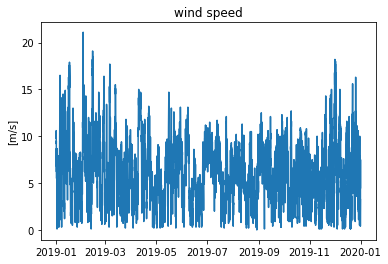

In [9]:
plt.figure()
plt.plot(ds['time'],ds['wind_spd'])
plt.title('wind speed')
plt.ylabel('[m/s]')

##### *Exercise*

Make a plot for wind *direction*, including title and axis label.

In [10]:
# insert code here

### Working with vector data

Vectors, like wind velocity, are characterized by a magnitude and direction. Scalars, like temperature, only have a magnitude. Vectors can be described in different ways. For example, instead of speed and direction, we can describe a wind vector in terms of its eastward and northward components.

#### Calculating vector components

NDBC provides data on wind speed and direction. Following typical meteorological convention, the direction describes the direction the wind is blowing from, clockwise from true north. We can convert the data to eastward and northward components. 

The eastward component describes how hard the wind is blowing towards the east. We will call this the $u$ component, where positive $u$ represents wind blowing toward the east and negative $u$ represents wind blowing toward the west.

Similarly, the northward component describes how hard the wind is blowing towards the north. We will call this the $v$ component, where positive $v$ represents wind blowing toward the north and negative $v$ represents wind blowing toward the south.

The function `wind_uv_from_spddir` converts wind vectors from speed and direction, as reported by NDBC, to eastward and northward components.

In [11]:
def wind_uv_from_spddir(wspd,wdir):
    '''Convert wind speed and direction to eastward and northward components.
    
    Inputs
    wspd - wind speed
    wdir - wind direction (wind is blowing FROM this direction, 
                           clockwise from true north)
    
    Output:
    u - eastward velocity component (TOWARDS the east)
    v - northward velocity component (TOWARDS the north)
    '''
    
    theta = np.array(wdir) # direction CW from true north
    theta = theta*np.pi/180. # convert to radians
    x = -np.sin(-theta)
    y = np.cos(-theta)
    theta_cart = np.arctan2(y,x) # direction CCW from east (Cartesian)
    u = -wspd*np.cos(theta_cart) # eastward component
    v = -wspd*np.sin(theta_cart) # northward component
    
    return u,v

In [12]:
ds['wind_east'],ds['wind_north'] = wind_uv_from_spddir(ds['wind_spd'],ds['wind_dir'])

In [13]:
ds['wind_east']

<xarray.DataArray 'wind_east' (time: 14855)>
array([0.17103359, 0.51289238, 1.84067075, ..., 2.58021354, 3.0564969 ,
       3.18198052])
Coordinates:
  * time       (time) datetime64[ns] 2019-01-01T00:50:00 ... 2019-12-31T23:50:00
    latitude   float32 36.78
    longitude  float32 -122.4

#### Plot the vector components

Plot the time series of eastward velocity and northward velocity (time on the x-axis, both eastward and northward velocity on the y-axis).

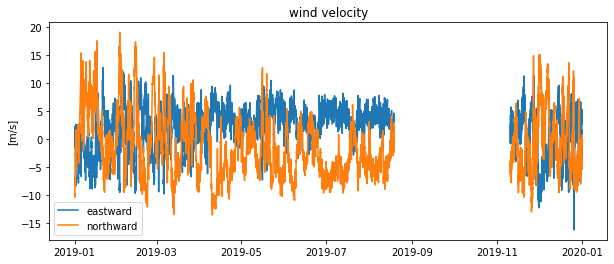

In [14]:
plt.figure(figsize=(10,4))
plt.plot(ds['time'],ds['wind_east'])
plt.plot(ds['time'],ds['wind_north'])
plt.ylabel('[m/s]')
plt.title('wind velocity')
plt.legend(['eastward','northward'])

##### *Exercise*

Identify a time when wind is blowing from the northwest and towards the southeast. This direction is favorable for upwelling along the California coast.

*(insert text here)*

#### Alignment of wind velocity

By plotting eastward wind vs. northward wind, we can see that the wind off Monterey Bay tends to blow towards the southeast (upwelling-favorable) or towards the northwest (downwelling-favorable). This is because the wind tends to be steered parallel to the local coastline by coastal mountain ranges along the west coast.

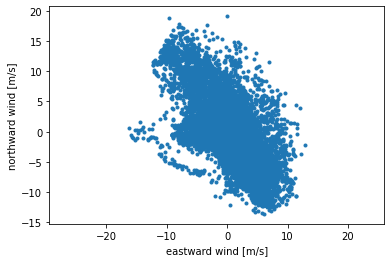

In [15]:
plt.figure()
plt.plot(ds['wind_east'],ds['wind_north'],'.')
plt.xlabel('eastward wind [m/s]')
plt.ylabel('northward wind [m/s]')
plt.axis('equal'); # make the scale equal on the x and y axes

### Coordinate system rotation

#### Rotating wind stress vectors

The northward and eastward components of wind stress are not always the most useful for studying upwelling. It is the alongshore component of wind stress (the component parallel to shore) that is most important for upwelling. The direction parallel to shore is not always conveniently aligned in the north-south or east-west directions.

To calculate the alongshore component of wind stress, the vectors are rotated from geographic coordinates (east and north) to "natural" coordinates (cross-shore and alongshore). The `rot` function rotates vectors to a new coordinate system defined by the user.

In [16]:
def rot(u,v,theta):
    """
Rotate a vector counter-clockwise OR rotate the coordinate system clockwise.
Usage:
ur,vr = rot(u,v,theta)
Input:
u,v - vector components (e.g. u = eastward velocity, v = northward velocity)
theta - rotation angle (degrees)
Output:
ur,vr - rotated vector components
Example:
rot(1,0,90) returns (0,1)
    """

    w = u + 1j*v             # complex vector
    ang = theta*np.pi/180    # convert angle to radians
    wr = w*np.exp(1j*ang)    # complex vector rotation
    ur = np.real(wr)         # return u and v components
    vr = np.imag(wr)
    return ur,vr

See what happens when the vectors are rotated 20 degrees clockwise.

In [17]:
rotation_angle = -20
ds['wind_x'],ds['wind_y'] = rot(ds['wind_east'],ds['wind_north'],rotation_angle)

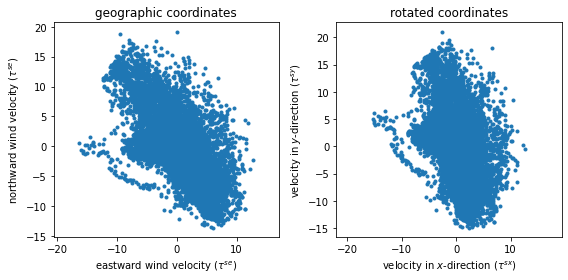

In [18]:
plt.figure(figsize=(8,4))
plt.subplot(121)
plt.plot(ds['wind_east'],ds['wind_north'],'.')
plt.axis('equal')
plt.xlabel('eastward wind velocity ($\\tau^{se}$)')
plt.ylabel('northward wind velocity ($\\tau^{se}$)')
plt.title('geographic coordinates')

plt.subplot(122)
plt.plot(ds['wind_x'],ds['wind_y'],'.')
plt.axis('equal')
plt.xlabel('velocity in $x$-direction ($\\tau^{sx}$)')
plt.ylabel('velocity in $y$-direction ($\\tau^{sy}$)')
plt.title('rotated coordinates')
plt.tight_layout()

##### Exercise

Modify the `rotation_angle` variable above and re-run the analysis. What angle makes the wind stress most aligned along the $y$ axis? What angle makes the wind stress most aligned along the $x$ axis?

#### Principal axis angle

Instead of trial and error, a principal axis analysis can be used to find the angle along which the wind stress is aligned. On the west coast, this typically corresponds with the local coastline. On the east coast, this is not necessarily case.

The `princax` function can be used to find the pricipal axis angle. The variance of the data is maximized along this axis.

In [19]:
def princax(u,v=None):
    '''
Principal axes of a vector time series.
Usage:
theta,major,minor = princax(u,v) # if u and v are real-valued vector components
    or
theta,major,minor = princax(w)   # if w is a complex vector
Input:
u,v - 1-D arrays of vector components (e.g. u = eastward velocity, v = northward velocity)
    or
w - 1-D array of complex vectors (u + 1j*v)
Output:
theta - angle of major axis (math notation, e.g. east = 0, north = 90)
major - standard deviation along major axis
minor - standard deviation along minor axis
Reference: Emery and Thomson, 2001, Data Analysis Methods in Physical Oceanography, 2nd ed., pp. 325-328.
Matlab function: http://woodshole.er.usgs.gov/operations/sea-mat/RPSstuff-html/princax.html
    '''

    # if one input only, decompose complex vector
    if v is None:
        w = np.copy(u)
        u = np.real(w)
        v = np.imag(w)

    # only use finite values for covariance matrix
    ii = np.isfinite(u+v)
    uf = u[ii]
    vf = v[ii]

    # compute covariance matrix
    C = np.cov(uf,vf)

    # calculate principal axis angle (ET, Equation 4.3.23b)
    theta = 0.5*np.arctan2(2.*C[0,1],(C[0,0] - C[1,1])) * 180/np.pi

    # calculate variance along major and minor axes (Equation 4.3.24)
    term1 = C[0,0] + C[1,1]
    term2 = ((C[0,0] - C[1,1])**2 + 4*(C[0,1]**2))**0.5
    major = np.sqrt(0.5*(term1 + term2))
    minor = np.sqrt(0.5*(term1 - term2))

    return theta,major,minor

Use this function on the wind stress data.

In [20]:
theta,major,minor = princax(ds['wind_east'],ds['wind_north'])

Rotate the wind data based on the principal axis angle. Note that it is common among oceanographers on the west coast to align the alongshore coordinate with the $y$-axis, but this is up to you.

In [21]:
ds['wind_x'],ds['wind_y'] = rot(ds['wind_east'],ds['wind_north'],-theta-90)

Text(0.5, 1.0, 'rotated coordinates')

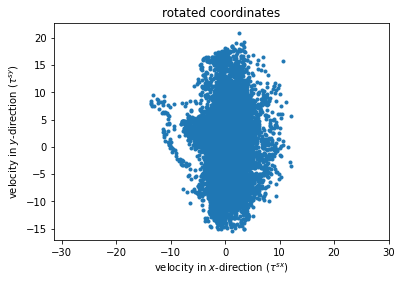

In [22]:
plt.figure()
plt.plot(ds['wind_x'],ds['wind_y'],'.')
plt.axis('equal')
plt.xlabel('velocity in $x$-direction ($\\tau^{sx}$)')
plt.ylabel('velocity in $y$-direction ($\\tau^{sy}$)')
plt.title('rotated coordinates')

Plot the time series. The negative values of the alongshore wind stress ($\tau^{sy}$) indicate upwelling-favorable winds. The positive values indicate downwelling favorable winds.

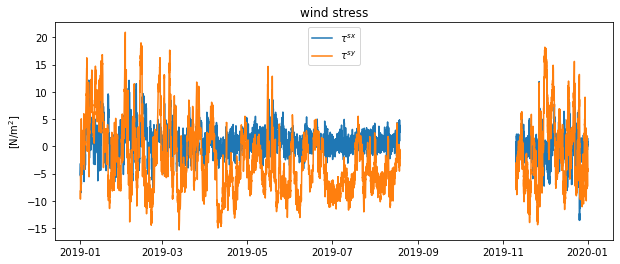

In [23]:
plt.figure(figsize=(10,4))
plt.plot(ds['time'],ds['wind_x'])
plt.plot(ds['time'],ds['wind_y'])
plt.ylabel('[N/m$^2$]')
plt.title('wind stress')
plt.legend(['$\\tau^{sx}$','$\\tau^{sy}$'])

##### Exercise

Apply this same analysis to another NDBC buoy on the west coast. 

* Find the buoy ID number using the map interface at https://www.ndbc.noaa.gov/
* In the `ncfile` variable above, replace 46042 with the new buoy ID number.
* Identify a time when the wind is favorable for upwelling.
* What rotation angle did you use?